In [109]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso, ARDRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
import torch
from torch import nn
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [4]:
with open(os.path.dirname(os.getcwd()) + "/model_data/oceanography_data.pkl", "rb") as file:
    oceanography_data = pickle.load(file)

In [5]:
old_method_data = pd.read_excel(os.path.dirname(os.getcwd()) + "/raw_data/old_method_data.xlsx")

with open(os.path.dirname(os.getcwd()) + "/conversions/area_names_map.pkl", "rb") as file:
    area_names_map = pickle.load(file)

old_method_data["Area"] = old_method_data["Area"].map(area_names_map)
old_method_data.sort_values(by=["Area", "Year"])

,Area,Year,S
50,21,2004,88.57143
51,21,2006,66.66667
52,21,2008,77.77778
53,21,2009,83.33333
54,21,2011,72.41379
...,...,...,...
135,87,2013,58.33333
136,87,2015,38.46000
137,87,2017,45.45000
138,87,2019,33.30000


In [106]:
X = []

# var_exclude = ["thetao_mean", "so_mean", "chl", "no3", "po4", "si", "nppv", "o2", "fe", "phyc", "ph", "spco2"]

for area, data in oceanography_data.items():
    a = {}
    for variable, var_data in data.items():
        for year, year_data in var_data.items():
            if year not in a:
                a[year] = []
            a[year] += list(year_data[variable])
    for d in a.values():
        X.append(d)

X = np.array(X)

y = np.array(list(old_method_data["S"]))

n_samples, n_features = X.shape

input_size = n_features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [76]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

R2 score on test: -0.49022662245223203


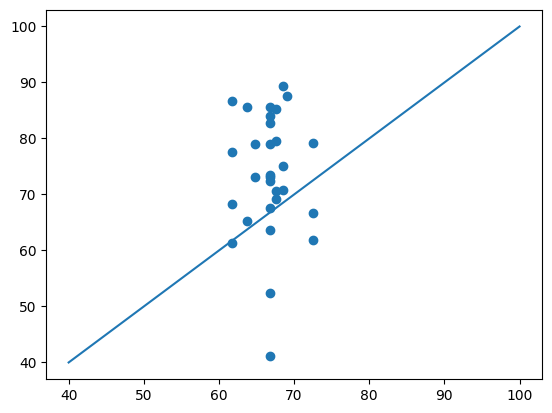

In [77]:
regr1 = svm.SVR(kernel="linear", C=1)

regr1.fit(X_train, y_train)
pred1 = regr1.predict(X_test)

print(f"R2 score on test: {r2_score(y_test, pred1)}")

plt.scatter(pred1, y_test)
plt.plot(np.linspace(40,100), np.linspace(40,100))

R2 score on test: -0.4284015893318962


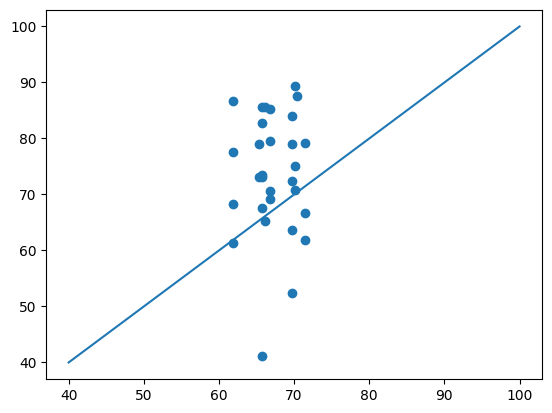

In [78]:
regr2 = Lasso(alpha=0.2)

regr2.fit(X_train, y_train)

pred2 = regr2.predict(X_test)

print(f"R2 score on test: {r2_score(y_test, pred2)}")

plt.scatter(pred2, y_test)
plt.plot(np.linspace(40,100), np.linspace(40,100))

R2 score on test: -0.3371691487420061


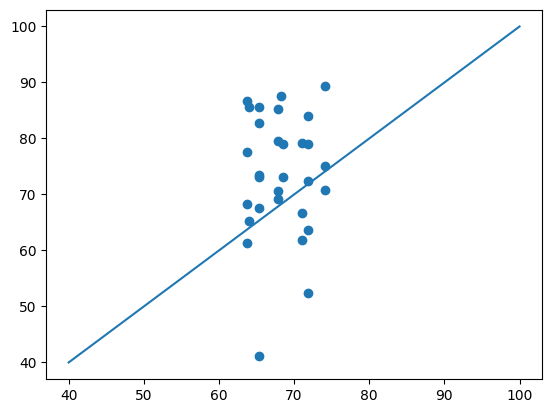

In [79]:
regr3 = RandomForestRegressor(max_depth=2, random_state=0)

regr3.fit(X_train, y_train)

pred3 = regr3.predict(X_test)

print(f"R2 score on test: {r2_score(y_test, pred3)}")

plt.scatter(pred3, y_test)
plt.plot(np.linspace(40,100), np.linspace(40,100))

R2 score on test: -0.42821761182997875


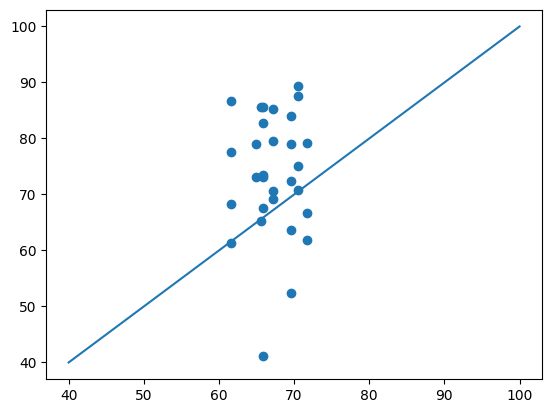

In [80]:
regr4 = ElasticNet(alpha=0.08, l1_ratio=0.5)

regr4.fit(X_train, y_train)

pred4 = regr4.predict(X_test)

print(f"R2 score on test: {r2_score(y_test, pred4)}")

plt.scatter(pred4, y_test)
plt.plot(np.linspace(40,100), np.linspace(40,100))

In [81]:
for model in [regr1, regr2, regr3, regr4]:
    sc = cross_val_score(model, X, y, cv=5)
    print(f"Mean score: {sc.mean()}. Std: {sc.std()}")

Mean score: -1.691124291157219. Std: 1.0944548471851856
Mean score: -1.4831658044483038. Std: 1.0411447694452318
Mean score: -1.4209072082519312. Std: 0.9522959448525239
Mean score: -1.4616813232951418. Std: 1.0256704025261993


In [104]:
vars = ["thetao_mean", "so_mean", "chl", "no3", "po4", "si", "nppv", "o2", "fe", "phyc", "ph", "spco2"]

def variable_score(var):
    X = []
    for area, data in oceanography_data.items():
        a = {}
        for variable, var_data in data.items():
            if variable == var:
                for year, year_data in var_data.items():
                    if year not in a:
                        a[year] = []
                    a[year] += list(year_data[variable])
                for d in a.values():
                    X.append(d)
            

    X = np.array(X)
    y = np.array(list(old_method_data["S"]))

    regr = RandomForestRegressor(max_depth=2, random_state=0)

    sc = cross_val_score(regr, X, y, cv=5)

    print(f"Mean score: {sc.mean()}. Std: {sc.std()} for variable {var}")


In [105]:
for var in vars:
    variable_score(var)

Mean score: -1.4209072082519312. Std: 0.9522959448525239 for variable thetao_mean
Mean score: -1.4369251332088944. Std: 0.9717330817556012 for variable so_mean
Mean score: -1.4282529138795845. Std: 0.9397714100628302 for variable chl
Mean score: -1.4271046768818474. Std: 0.9571021961663905 for variable no3
Mean score: -1.4260047894456318. Std: 0.9383554025695765 for variable po4
Mean score: -1.4263959283829333. Std: 0.9786403632133769 for variable si
Mean score: -1.418033884296. Std: 0.9364959760763966 for variable nppv
Mean score: -1.4225618240193658. Std: 0.9429985713157454 for variable o2
Mean score: -1.4233270027513325. Std: 0.9557229320900713 for variable fe
Mean score: -1.4272169512394928. Std: 0.9414327189847488 for variable phyc
Mean score: -1.4266974570542064. Std: 0.9214052041543929 for variable ph
Mean score: -1.4275761096480106. Std: 0.9257588933161818 for variable spco2


In [113]:
fval, pval = f_regression(X,y)

print(pd.DataFrame([[f,p] for f,p in zip(fval, pval)], columns=["F-value", "P-value"]))

      F-value   P-value
0    0.152341  0.696870
1    0.010690  0.917793
2    0.534608  0.465832
3    1.030312  0.311742
4    1.336923  0.249440
..        ...       ...
139  9.981183  0.001918
140  9.693902  0.002220
141  9.677473  0.002239
142  9.626029  0.002298
143  9.710919  0.002201

[144 rows x 2 columns]
